In [5]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt

from matplotlib.dates import date2num, num2date
from matplotlib import dates as mdates
from matplotlib import ticker
from matplotlib.colors import ListedColormap
from matplotlib.patches import Patch
from matplotlib import pyplot as plt
import scipy

import sys

sys.path.insert(0, '..')

### ---- ###
from functions.adjust_cases_functions import prepare_cases
from global_config import config



#dict_map = {'0-19': (0,19), '20-39': (20,39), '40-49': (40,49),
#            '50-59': (50,59), '60-69': (60,69), '70-90+': (70,200) }


dict_map = {'10-10': (0,19), '10-19': (10, 19), '20-39': (20,39), '40-49': (40,49),
            '50-59': (50,59), '60-69': (60,69), '70-90+': (70,200) }

NGroups  = len(dict_map)

def age_group(val, dict_map):
    for ag in dict_map:
        if dict_map[ag][0] <= val <= dict_map[ag][1]:
            return ag
    return 'NaN'

data_dir      = config.get_property('data_dir_covid')
data_dir_mnps = config.get_property('data_dir_col')
results_dir   = config.get_property('results_dir')

location_folder = 'colombia'
agglomeration_method = 'geometry'
type_run = 'all'


In [7]:


# Agglomerated folder location
agglomerated_folder = os.path.join(data_dir, 'data_stages', location_folder, 'agglomerated', agglomeration_method )

raw_folder          = os.path.join(data_dir, 'data_stages', location_folder, 'raw' , 'cases')

poly_agg_path  = os.path.join(data_dir_mnps, 'administrative_division_col_2018.csv' )
poly_agg_df    = pd.read_csv(poly_agg_path, sep =',').set_index('poly_id')


cases_df_all = pd.read_csv(os.path.join(agglomerated_folder, 'cases.csv'), parse_dates =['date_time']).set_index('poly_id')
cases_df = cases_df_all.copy()

#poly_id2location = cases_df.copy().reset_index().groupby(['poly_id', 'location']).sum().reset_index()[['poly_id', 'location']].set_index('poly_id')

cases_raw_df = pd.read_csv(os.path.join(raw_folder, 'cases_raw.csv'), parse_dates =['Fecha de inicio de síntomas', 'Fecha de diagnóstico', 'Fecha de muerte'], dayfirst=True) #.set_index('poly_id')
cases_raw_df['age_group'] = cases_raw_df['Edad'].apply(lambda x: age_group( x, dict_map) )
cases_raw_df = cases_raw_df[['Código DIVIPOLA municipio', 'Nombre municipio', 'Nombre departamento',  'age_group', 'Sexo' ,'Fecha de inicio de síntomas', 'Fecha de diagnóstico', 'Fecha de muerte']]
cases_raw_df = cases_raw_df.rename(columns={'Código DIVIPOLA municipio': 'poly_id'})

#poly_id2location = cases_raw_df.copy().reset_index().groupby(['poly_id','Nombre municipio', 'Nombre departamento']).sum().reset_index().set_index('poly_id')
#poly_id2location['location'] = poly_id2location.apply(lambda x: x['Nombre municipio'].lower()+'-'+x['Nombre departamento'].lower(), axis=1).reset_index()

list_df_ages = []
for age_g in dict_map.keys():
    cases_agei = cases_raw_df[cases_raw_df.age_group==age_g].copy()
    cases_agei['num_cases']    = 1
    cases_agei['num_diseased'] = 1
    cases_agei_num_cases  = cases_agei.copy().groupby(['Fecha de diagnóstico','poly_id']).sum().reset_index().rename(columns={'Fecha de diagnóstico': 'date_time'})[['date_time','poly_id','num_cases']]
    cases_agei_num_deaths = cases_agei.copy()[['Fecha de muerte','poly_id','num_diseased']].dropna().groupby(['Fecha de muerte','poly_id']).sum().reset_index().rename(columns={'Fecha de muerte': 'date_time'})
    new_df = pd.merge(cases_agei_num_cases, cases_agei_num_deaths,  how='outer').fillna(0)
    new_df = new_df.groupby(['date_time','poly_id']).sum().reset_index().set_index('poly_id')
    new_df['age_group'] = age_g
    list_df_ages.append(new_df)

cases_df_agg = cases_df.reset_index()[['poly_id','date_time', 'num_cases', 'num_diseased']]
cases_df_agg['age_group'] = 'agg'
list_df_ages.append(cases_df_agg.set_index('poly_id'))
df_cases_ages = pd.concat(list_df_ages)

poly_df  = pd.read_csv(os.path.join(agglomerated_folder, 'polygons.csv')).set_index('poly_id')

## add time delta
df_polygons = pd.read_csv( os.path.join( agglomerated_folder ,  "polygons.csv") )

# Time delay between FIS and diagnosis date
poly_df   = pd.read_csv( os.path.join( agglomerated_folder ,  "polygons.csv") ).set_index('poly_id')
pop_df = poly_df.copy()[['attr_area', 'geometry', 'attr_population']]

poly_df = poly_df.dropna(subset=['attr_time-delay_dist_mix', 'attr_time_death-delay_dist_mix'], axis='rows')

poly_df["attr_time-delay_dist_mix"] = poly_df["attr_time-delay_dist_mix"].fillna("")
poly_df = poly_df.dropna(subset=['attr_time-delay_dist_mix'], axis=0)
poly_df["attr_time_diag_delay"] = poly_df.apply(lambda x: np.fromstring(x["attr_time-delay_dist_mix"], sep="|"), axis=1)
poly_df = poly_df[poly_df['attr_time_diag_delay'].map(lambda x: len(x)) > 0]
poly_df = poly_df[poly_df['attr_time_diag_delay'].map(lambda x: ~np.isnan(list(x)[0] ))]


poly_df["attr_time_death-delay_dist_mix"] = poly_df["attr_time_death-delay_dist_mix"].fillna("")
poly_df["attr_time_death_delay"]          = poly_df.apply(lambda x: np.fromstring(x["attr_time_death-delay_dist_mix"], sep="|"), axis=1)
poly_df = poly_df.dropna(subset=['attr_time_death-delay_dist_mix'], axis=0)
poly_df["attr_time_death_delay"] = poly_df.apply(lambda x: np.fromstring(x["attr_time_death-delay_dist_mix"], sep="|"), axis=1)
poly_df = poly_df[poly_df['attr_time_death_delay'].map(lambda x: len(x)) > 0]
poly_df = poly_df[poly_df['attr_time_death_delay'].map(lambda x: ~np.isnan(list(x)[0] ))]

agg_p_delay_diag  = pd.DataFrame(list(poly_df['attr_time_diag_delay'])).mean().to_numpy()
agg_p_delay_diag[0] = 0

agg_p_delay_death = pd.DataFrame(list(poly_df['attr_time_death_delay'])).mean().to_numpy()
agg_p_delay_death[0] = 0

def crosscorr(cases, deaths, lag=0):
    """ Lag-N cross correlation. 
    Parameters
    ----------
    lag : int, default 0
    datax, datay : pandas.Series objects of equal length

    Returns
    ----------
    crosscorr : float
    """
    return deaths.corr(cases.shift(lag))


def compute_correlation(cases, deaths, lags = list(range(41)), start_day='01-04-2020', final_day=None):

    if not start_day:
        start_day = min(cases.index.values[0], deaths.index.values[0])
    if not final_day:
        final_day = min(cases.index.values[-1], deaths.index.values[-1])

    min_date = pd.to_datetime(start_day, dayfirst=True)
    max_date = pd.to_datetime(final_day, dayfirst=True)

    cases = cases.loc[start_day:max_date]
    deaths = deaths.loc[start_day:max_date]

    corr_df = pd.DataFrame(columns = ['lag', 'value'])
    corr_df['lag'] = lags
    corr_df = corr_df.set_index('lag')

    for idx, lag in enumerate(lags):
        corr_df.loc[lag]['value'] = crosscorr(cases, deaths, lag=lag)

    return corr_df


def cfr(cases, deaths, lag, start_day='01-04-2020', final_day=None):

    if not start_day:
        start_day = min(cases.index.values[0], deaths.index.values[0])
    if not final_day:
        final_day = min(cases.index.values[-1], deaths.index.values[-1])

    #start_day = '01-04-2020'
    #final_day = '31-10-2020'

    min_date = pd.to_datetime(start_day, dayfirst=True)
    max_date = pd.to_datetime(final_day, dayfirst=True)

    min_init = min(cases.index.values[0], deaths.index.values[0])
    min_date = min(min_date, min_init)

    max_init = min(cases.index.values[-1], deaths.index.values[-1])
    max_date = min(max_date, max_init)


    cases = cases.loc[min_date:max_date]
    deaths = deaths.loc[min_date:max_date]

    cfr = pd.DataFrame(columns = ['date_time', 'value'])

    #cfr['date_time'] = pd.date_range(start=min_date, end=max_date, freq='D')
    #cfr['value']     = deaths.shift(lag).values / cases.values

    return deaths.shift(lag).values / cases.values

cases_df['state']    = cases_df.apply(lambda x: x['location'].split('-')[-1], axis=1)
state2id = {}
for state_id in cases_df['state'].unique():
    poly_id = str(cases_df.reset_index().set_index("state").loc[state_id]['poly_id'].iloc[0])
    if len(poly_id)==4: #==state_id")['poly_id'].iloc[0])==4:
        state2id[state_id] = '0'+poly_id[:1]
    else:
        state2id[state_id] = poly_id[:2]

def get_location_state(poly_id, cases_df_all):
    try:
        location = cases_df_all.loc[poly_id]['location'].iloc[0]
    except:
        return 'None'

    return (location.split('-')[0], location.split('-')[1])

from tqdm import tqdm
poly_info = {}
for idx, poly_id in tqdm(enumerate(cases_df.reset_index()['poly_id'].unique())):

    # If polygon not in polygons use aggregated p_delay
    if poly_id in poly_df.index.values:
        p_delay_diag = poly_df.loc[poly_id]["attr_time_diag_delay"]
    else:
        p_delay_diag = agg_p_delay_diag

    if poly_id in poly_df.index.values:
        p_delay_death = poly_df.loc[poly_id]["attr_time_death_delay"]
    else:
        p_delay_death = agg_p_delay_death

    try:
        list_cases_df = []
        for age_group in df_cases_ages.age_group.unique():
            cases_df = df_cases_ages[df_cases_ages.age_group==age_group]
            cases  = cases_df.loc[poly_id][['date_time','num_cases']].set_index('date_time').resample('D').sum().fillna(0)[['num_cases']]
            cases  = prepare_cases(cases, col='num_cases', cutoff=0)
            cases['age_group'] = age_group
            list_cases_df.append(cases)
        cases = pd.concat(list_cases_df)

    except:
        continue

    list_deaths_df = []
    for age_group in df_cases_ages.age_group.unique():
        deaths_df = df_cases_ages[df_cases_ages.age_group==age_group]
        deaths  = deaths_df.loc[poly_id][['date_time','num_diseased']].set_index('date_time').resample('D').sum().fillna(0)[['num_diseased']]
        deaths['age_group'] = age_group
        list_deaths_df.append(deaths)
    deaths = pd.concat(list_deaths_df)



    if deaths[deaths.age_group=='agg']['num_diseased'].sum() <= 100:
        continue
    start_date = deaths[deaths.age_group=='agg'].index.values[np.where(deaths[deaths.age_group=='agg']['num_diseased'].cumsum()>=1)[0][0]] + pd.Timedelta(days=8)
    #df_corr_poly_id = compute_correlation(cases_onset['num_cases'], deaths['num_diseased'], lags = list(range(41)), start_day=start_date, final_day='31-10-2020')

    poly_info[poly_id] = {
                    'poly_id'         : poly_id,
                    'poly_name'       : get_location_state(poly_id, cases_df_all)[0],
                    'state'           : get_location_state(poly_id, cases_df_all)[1],
                    'population'      : pop_df.loc[poly_id]['attr_population'],
                    'area'            : pop_df.loc[poly_id]['attr_area'],
                    'delay_diag'      : p_delay_diag,
                    'delay_death'     : p_delay_death,
                    'geometry'        : pop_df.loc[poly_id]['geometry']
                    }
    # TODO: add                key 'corr_lag'        : df_corr_poly_id
    path_to_save = os.path.join( results_dir, 'colombia', 'cfr')

    for age_group in deaths.age_group.unique():
        cases_ag = cases[cases.age_group==age_group][['num_cases', 'smoothed_num_cases']]
    
        poly_info[poly_id]['cases_diag_{}'.format(age_group)]  = cases_ag
        poly_info[poly_id]['cases_onset_{}'.format(age_group)] = confirmed_to_onset(cases_ag['smoothed_num_cases'], p_delay_diag, 'num_cases')
        poly_info[poly_id]['deaths_{}'.format(age_group)]      = deaths[deaths.age_group==age_group][['num_diseased']]

/Users/chaosdonkey06/conda/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3146: DtypeWarning: Columns (14,22) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
1102it [06:01,  3.05it/s]


In [23]:
poly_df

,attr_area,geometry,attr_population,poly_name,poly_lon,poly_lat,attr_time-delay_dist_mix,attr_time_death-delay_dist_mix,num_cases,num_diseased,num_recovered,num_infected,num_infected_in_hospital,num_infected_in_house,attr_time_diag_delay,attr_time_death_delay
poly_id,,,,,,,,,,,,,,,,
5480,1.140242e+09,POLYGON ((-7366270.208146195 966538.7801907029...,22028.0,Mutatá-Antioquia,-76.489954,7.340448,0.0|0.00014483979331319426|0.00264708919863248...,0.0|8.72077126550332e-06|0.0002415252706354030...,173.0,8.0,0.0,163.0,1.0,162.0,"[0.0, 0.00014483979331319426, 0.00264708919863...","[0.0, 8.72077126550332e-06, 0.0002415252706354..."
5266,8.061037e+07,POLYGON ((-7269356.932044757 793208.7725557629...,238173.0,Envigado-Antioquia,-75.546215,6.153387,0.0|0.010157027444787985|0.035504887530424634|...,0.0|0.0011815713163460027|0.004445167432261699...,19227.0,289.0,0.0,18878.0,76.0,18802.0,"[0.0, 0.010157027444787985, 0.0355048875304246...","[0.0, 0.0011815713163460027, 0.004445167432261..."
5483,3.176878e+08,POLYGON ((-7246077.704231423 728105.9428184908...,17891.0,Nariño-Antioquia,-75.194737,5.581354,0.0|1.3023639347851833e-30|1.400435699508082e-...,0.0|0.0015947009144789935|0.01848523982387295|...,90.0,4.0,0.0,84.0,1.0,83.0,"[0.0, 1.3023639347851833e-30, 1.40043569950808...","[0.0, 0.0015947009144789935, 0.018485239823872..."
5490,1.279576e+09,"POLYGON ((-7379090.34363889 1114196.280273739,...",67359.0,Necoclí-Antioquia,-76.673569,8.493339,0.0|0.0006988691145611643|0.00548829437055723|...,0.0|0.005350004848380006|0.015577005438912472|...,481.0,30.0,0.0,447.0,4.0,443.0,"[0.0, 0.0006988691145611643, 0.005488294370557...","[0.0, 0.005350004848380006, 0.0155770054389124..."
5501,8.736602e+07,POLYGON ((-7296891.861119976 853922.9445331625...,3341.0,Olaya-Antioquia,-75.775707,6.610969,0.0|0.014269146246751208|0.02860906549957376|0...,0.0|0.03585777920039448|0.043061953935149125|0...,56.0,2.0,0.0,54.0,0.0,54.0,"[0.0, 0.014269146246751208, 0.0286090654995737...","[0.0, 0.03585777920039448, 0.04306195393514912..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95025,1.236223e+10,POLYGON ((-6968569.865792243 310950.7737247618...,24155.0,El Retorno-Guaviare,-71.516387,2.085258,0.0|8.249188625673382e-15|3.0957469077854953e-...,0.0|6.253635510021975e-11|1.4272159369756155e-...,109.0,6.0,0.0,103.0,0.0,103.0,"[0.0, 8.249188625673382e-15, 3.095746907785495...","[0.0, 6.253635510021975e-11, 1.427215936975615..."
97001,1.616207e+10,POLYGON ((-6787630.756857696 230791.2400106007...,32457.0,Mitú-Vaupés,-70.410907,1.030019,0.0|0.0008898472619864071|0.007033440816095874...,0.0|2.7377873763928253e-06|6.494998023580757e-...,930.0,12.0,0.0,915.0,1.0,914.0,"[0.0, 0.0008898472619864071, 0.007033440816095...","[0.0, 2.7377873763928253e-06, 6.49499802358075..."
99001,1.224123e+10,POLYGON ((-6526662.895184634 808389.3219154051...,16504.0,Puerto Carreño-Vichada,-68.145441,5.835140,0.0|0.0038927881048766012|0.012438384167281168...,0.0|0.0012391007456398339|0.004773872882580396...,1208.0,15.0,0.0,1191.0,3.0,1188.0,"[0.0, 0.0038927881048766012, 0.012438384167281...","[0.0, 0.0012391007456398339, 0.004773872882580..."


In [54]:
magdalena_df

,geometry,num_cases,num_diseased,attr_population,poly_name,state_name,mun_name,cases_frac,deaths_frac
poly_id,,,,,,,,,
47001,POLYGON ((-7130531.730915718 1447731.908168704...,32083.0,873.0,507324.0,Santa Marta-Magdalena,Magdalena,Santa Marta,70.234238,52.590361
47189,POLYGON ((-7137748.303389721 1416811.036910343...,4921.0,314.0,105208.0,Ciénaga-Magdalena,Magdalena,Ciénaga,10.772767,18.915663
47288,POLYGON ((-7089323.461567507 1358891.618325272...,1324.0,66.0,57527.0,Fundación-Magdalena,Magdalena,Fundación,2.898424,3.975904
47245,POLYGON ((-7125649.314531051 1193111.579743838...,948.0,63.0,55949.0,El Banco-Magdalena,Magdalena,El Banco,2.075306,3.795181
47555,POLYGON ((-7169615.019980205 1280147.203644642...,939.0,53.0,60824.0,Plato-Magdalena,Magdalena,Plato,2.055604,3.192771
47570,POLYGON ((-7151846.706918393 1404448.197959903...,569.0,47.0,32346.0,Puebloviejo-Magdalena,Magdalena,Puebloviejo,1.245622,2.831325
47980,POLYGON ((-7144793.860432096 1398730.473301491...,574.0,45.0,61829.0,Zona Bananera-Magdalena,Magdalena,Zona Bananera,1.256567,2.710843
47053,POLYGON ((-7100097.305080548 1386432.472723784...,506.0,25.0,40879.0,Aracataca-Magdalena,Magdalena,Aracataca,1.107706,1.506024
47551,POLYGON ((-7168401.066023508 1363029.177333943...,738.0,22.0,33400.0,Pivijay-Magdalena,Magdalena,Pivijay,1.615587,1.325301


In [66]:
np.concatenate??

array([70.23423818, 10.77276708,  2.89842382,  2.07530648,  2.0556042 ,
        1.24562172,  1.25656743,  1.10770578,  1.61558669,  0.39185639,
        0.52977233,  0.46190893,  0.42688266,  0.70052539,  0.36120841,
        0.19702277,  0.42688266,  0.59982487,  0.2561296 ,  0.66768827,
        0.28458844,  0.18607706,  0.15980736,  0.22329247,  0.14886165,
        0.21672504,  0.20796848,  0.29115587, 52.59036145, 18.91566265,
        3.97590361,  3.79518072,  3.19277108,  2.8313253 ,  2.71084337,
        1.5060241 ,  1.3253012 ,  1.20481928,  0.78313253,  0.78313253,
        0.72289157,  0.6626506 ,  0.6626506 ,  0.60240964,  0.54216867,
        0.48192771,  0.42168675,  0.42168675,  0.36144578,  0.36144578,
        0.30120482,  0.24096386,  0.24096386,  0.12048193,  0.12048193,
        0.12048193])

In [150]:
magdalena_df

,geometry,num_cases,num_diseased,attr_population,poly_name,state_name,mun_name,frac,type
poly_id,,,,,,,,,
47001,POLYGON ((-7130531.730915718 1447731.908168704...,32083.0,873.0,507324.0,Santa Marta-Magdalena,Magdalena,Santa Marta,70.234238,Cases
47189,POLYGON ((-7137748.303389721 1416811.036910343...,4921.0,314.0,105208.0,Ciénaga-Magdalena,Magdalena,Ciénaga,10.772767,Cases
47288,POLYGON ((-7089323.461567507 1358891.618325272...,1324.0,66.0,57527.0,Fundación-Magdalena,Magdalena,Fundación,2.898424,Cases
47245,POLYGON ((-7125649.314531051 1193111.579743838...,948.0,63.0,55949.0,El Banco-Magdalena,Magdalena,El Banco,2.075306,Cases
47555,POLYGON ((-7169615.019980205 1280147.203644642...,939.0,53.0,60824.0,Plato-Magdalena,Magdalena,Plato,2.055604,Cases
47570,POLYGON ((-7151846.706918393 1404448.197959903...,569.0,47.0,32346.0,Puebloviejo-Magdalena,Magdalena,Puebloviejo,1.245622,Cases
47980,POLYGON ((-7144793.860432096 1398730.473301491...,574.0,45.0,61829.0,Zona Bananera-Magdalena,Magdalena,Zona Bananera,1.256567,Cases
47053,POLYGON ((-7100097.305080548 1386432.472723784...,506.0,25.0,40879.0,Aracataca-Magdalena,Magdalena,Aracataca,1.107706,Cases
47551,POLYGON ((-7168401.066023508 1363029.177333943...,738.0,22.0,33400.0,Pivijay-Magdalena,Magdalena,Pivijay,1.615587,Cases


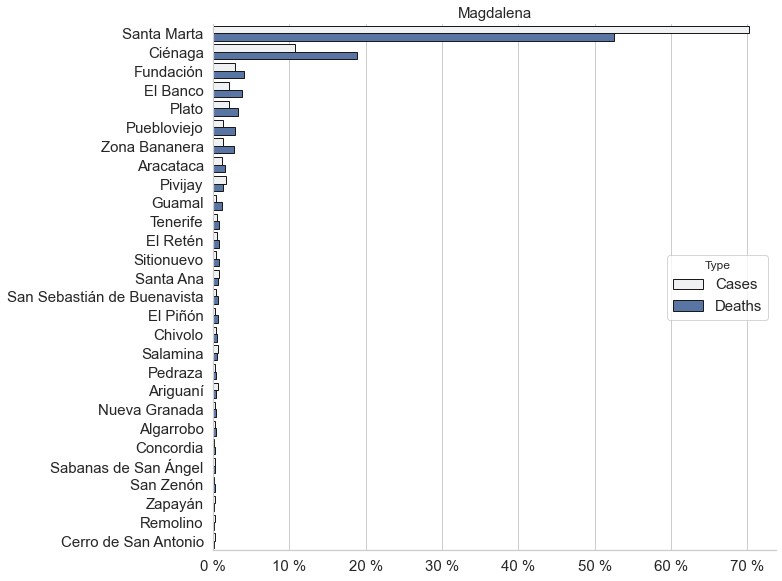

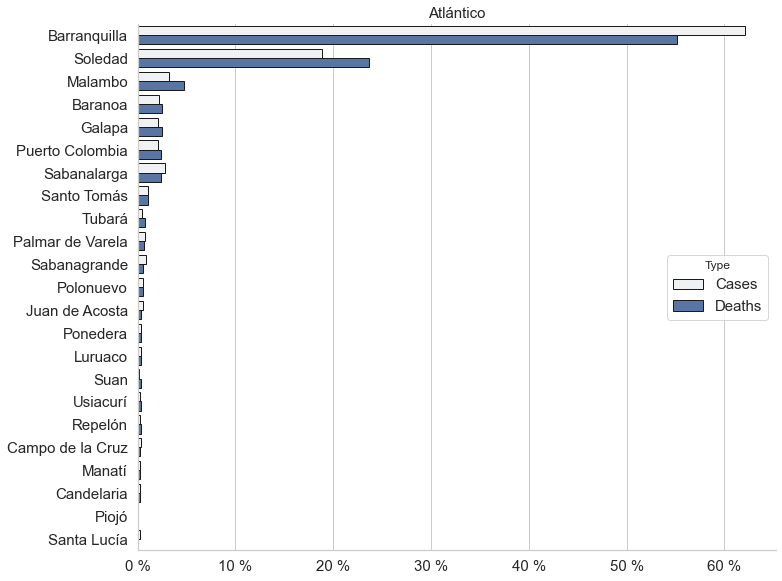

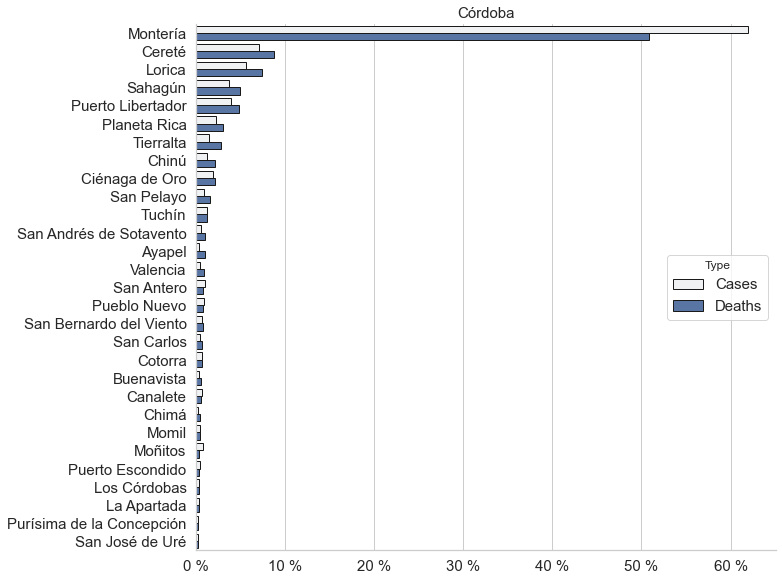

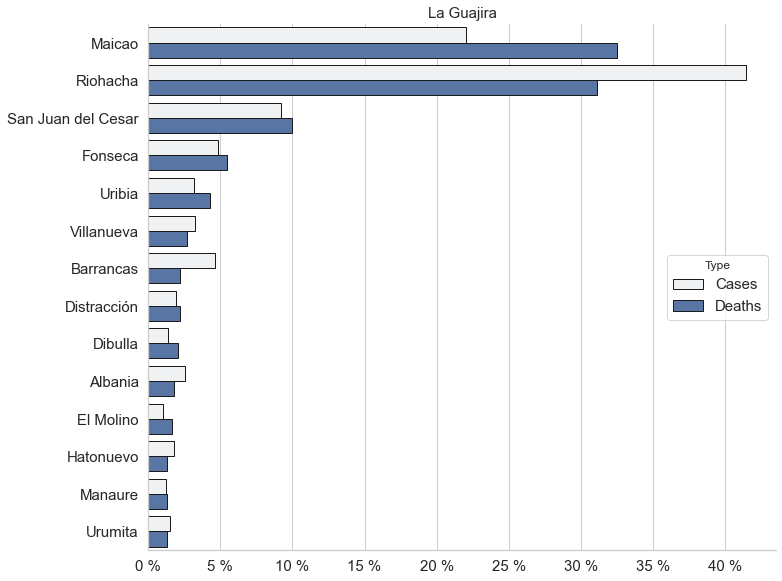

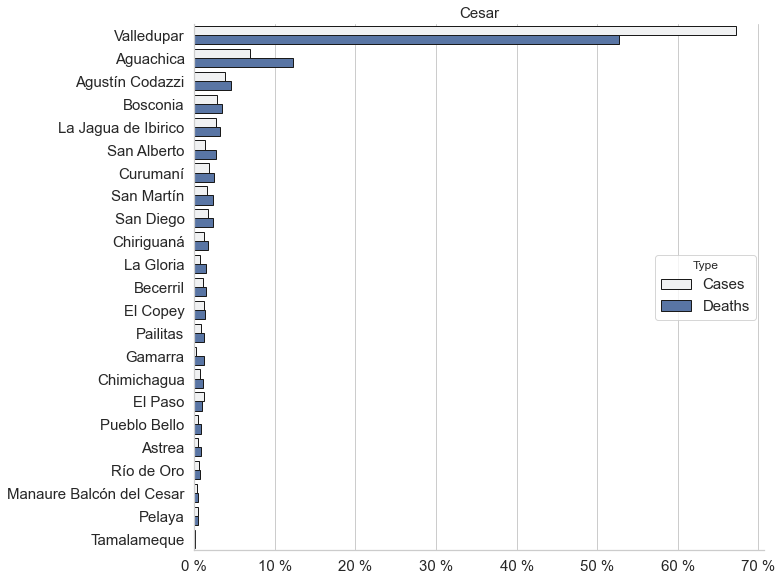

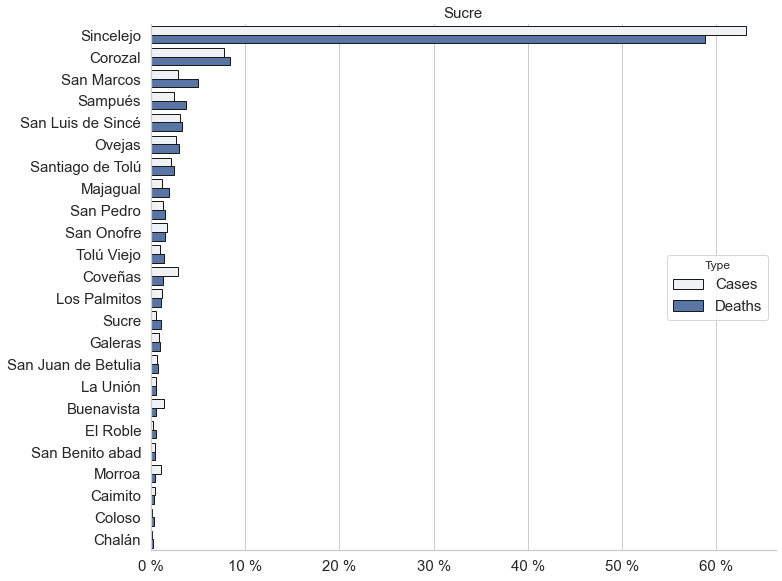

In [157]:
import seaborn as sns
sns.set_color_codes("pastel")
sns.set_theme(style="whitegrid")


state_df = poly_df.copy(); state_df = state_df[["geometry", "num_cases", "num_diseased", "attr_population", "poly_name"]]
state_df["state_name"] = state_df.apply(lambda x: x.poly_name.split('-')[-1], axis=1)
state_df["mun_name"] = state_df.apply(lambda x: x.poly_name.split('-')[0], axis=1)


# Costa

def plot_incident_prop(incident_df, title, path_to_save=None):
    
    incident_df  = incident_df.sort_values(by='num_diseased', ascending=False)
    frac         = np.concatenate((100 * incident_df["num_cases"].values / incident_df["num_cases"].sum(), 100 * incident_df["num_diseased"].values / incident_df["num_diseased"].sum())  )

    incident_df = pd.concat([incident_df, incident_df])
    incident_df['frac']  = frac
    incident_df['type']  = ['Cases']* (len(incident_df)//2) + ['Deaths']*(len(incident_df)//2)

    ax = sns.catplot(x="frac", y="mun_name", hue='type', data=incident_df,  edgecolor='k', color="b", kind='bar', height=8, aspect=5/4)
    sns.despine(top=True, right=True)
    ax.legend.set_visible(False)
    ax.axes[0][0].xaxis.set_major_formatter(ticker.StrMethodFormatter("{x:.0f} %"))
    ax.axes[0][0].tick_params(axis='both', labelsize=15)
    ax.axes[0][0].set_ylabel(None)
    ax.axes[0][0].set_xlabel(None)
    ax.axes[0][0].legend(loc="center right", frameon=True, title='Type', fontsize=15)
    plt.tight_layout()
    
    if title:
        plt.title(title, fontsize=15)

    if path_to_save:
        ax.fig.savefig(path_to_save,  dpi=300,  bbox_inches='tight', transparent=True)

list_state   = ['Magdalena' ,'Atlántico' , 'Córdoba' , 'La Guajira' , 'Cesar' , 'Sucre']

for st in list_state:
    plot_incident_prop(state_df[state_df.state_name==st], title=st, path_to_save=None)
    plt.show()

ax

<AxesSubplot:xlabel='Proportion %', ylabel='mun_name'>